 # Project: 01_Titanic Survival

In [1]:
#disable warnings
import sys
import warnings

if not sys.warnoptions:
    warnings.simplefilter("ignore")

In [2]:
 import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import PolynomialFeatures
import seaborn as sns
import re
import operator
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import train_test_split
from sklearn.model_selection import learning_curve
from sklearn.model_selection import validation_curve
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression

# import csv fiels and show shapes
titanic = pd.read_csv('train.csv', header=0 ) # names = ["PassengerId","Survived","Pclass","Name","Sex","Age","SibSp","Parch","Ticket","Fare","Cabin","Embarked"])
titanic_predict = pd.read_csv('predict.csv', header=0 )
titanic.shape, titanic_predict.shape

((891, 12), (418, 11))

### Looking at the Dataframe

In [3]:
# Descriptive statistics of the titanic DF
titanic.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [4]:
#look at titanic DF
titanic.tail(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.00,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.00,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.45,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.00,C148,C
890,891,0,3,"Dooley, Mr. Patrick",male,32.0,0,0,370376,7.75,NaN,Q


In [5]:
# taken from https://github.com/mheerens/ml_essentials/blob/master/preprocess_train.py

import config
"""PREPROCESS TRAININGDATA:
IN: csv file that contains X as well as y
OUT: separate files for X and y preprocessed for training
"""
import pickle
import numpy as np
import pandas as pd
from scipy import stats
from sklearn.decomposition import PCA
from sklearn.feature_selection import (SelectFromModel, SelectKBest,VarianceThreshold, chi2, f_classif)
from sklearn.impute import SimpleImputer
from sklearn.linear_model import Lasso
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import LinearSVC
from config import (PATH_MODELS, PATH_XTRAIN,
                    PATH_XTRAIN_PREPROCESSED, PATH_YTRAIN_PREPROCESSED,
                    SEPARATOR, Y_COLUMN)
from feature_engineering import engineer_train as feature_engineer_train
def save_column_structure(X):
    '''saves dataframe with one row to disc, is used than later as a "blueprint"
    for the test data, e.g. if one-hot-encoded features differ between train/test'''
    trainingdata_structure = X.head(1)
    with open(f'{PATH_MODELS}support/trainingdata.structure', 'wb') as handle:
        pickle.dump(trainingdata_structure, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Impute NAN
def impute_numerical_NaNs(X, strategy="mean", missing_values=np.nan):
    '''performs imputation on all numeric columns within dataframe'''
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    numeric_columns = list(X.select_dtypes(include=numerics))
    for col in numeric_columns:
        imp = SimpleImputer(missing_values, strategy)
        columndata = X[col].values.reshape(-1, 1)
        imp.fit(columndata) 
        X[col] = imp.transform(columndata)
        with open(f'{PATH_MODELS}support/imputer_{col}.model', 'wb') as handle:
            pickle.dump(imp, handle, protocol=pickle.HIGHEST_PROTOCOL)
    return X

# SCALING
def scale_column(columndata, columnlabel, feature_range):
    '''scales column accoring to given feature_range, e.g. (0,1)'''
    m = MinMaxScaler(feature_range=feature_range)
    X = columndata.values.reshape(-1, 1)
    m.fit(X)
    with open(f'{PATH_MODELS}support/scaler{feature_range}{columnlabel}.model', 'wb') as handle:
        pickle.dump(m, handle, protocol=pickle.HIGHEST_PROTOCOL)
    out = m.transform(X)
    return out

def scaling(X, feature_range):
    '''scales whole dataframe'''
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    numeric_columns = list(X.select_dtypes(include=numerics))
    for col in numeric_columns:
        X[col] = scale_column(X[col], col, feature_range)
    print(f"AFTER SCALING {feature_range}: {type(X)} - {X.shape}\n")
    return

# WORKING WITH CATHEGORICAL DATA
def one_hot_encoding(X):
    '''creates new column for each category within categorical column'''
    object_columns = list(X.select_dtypes(include=['object']))
    X = pd.get_dummies(X, prefix=object_columns)
    save_column_structure(X)
    print(f"ONE-HOT-ENCODING: {type(X)} - {X.shape}\n")
    return X

def factorization_encoding(X):
    '''encodes categorical columns with order of appearance
    . side effect: NaNs are being replaced by -1'''
    object_columns = list(X.select_dtypes(include=['object']))
    for col in object_columns:
        labels, uniques = pd.factorize(X[col], sort=True)
        X[col] = labels.astype('int32')
        #create encoding dict for applying on test data
        encoder = {}
        for i, value in enumerate(uniques):
            encoder[value] = i
        with open(f'{PATH_MODELS}support/factorization_encoder_{col}.dict', 'wb') as handle:
            pickle.dump(encoder, handle, protocol=pickle.HIGHEST_PROTOCOL)
    print(f"FACTORIZATION ENCODING: {type(X)} - {X.shape}\n")
    return X

# not used:
#import featuretools as ft
#ft

### Creating y-vector and X-matrix

In [6]:
#y vector
y = titanic['Survived']
# X MAtrix
X = titanic.iloc[:,2:]
#X = pd.merge(X1, X2, how = 'left') #, on = 'index') 
# add PassengerId
X['PassengerId'] = titanic['PassengerId'] 
X.tail(5)

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,PassengerId
886,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.00,NaN,S,887
887,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.00,B42,S,888
888,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.45,NaN,S,889
889,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.00,C148,C,890
890,3,"Dooley, Mr. Patrick",male,32.0,0,0,370376,7.75,NaN,Q,891


In [7]:
# Inspecting NaNs 
X.isnull().sum()

Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
PassengerId      0
dtype: int64

In [8]:
Xvec = X.iloc[:, [0,7]] #X['Pclass'] + X['Sex'] + X['Ticket'] 
Xvec.head()

,Pclass,Fare
0,3,7.2500
1,1,71.2833
2,3,7.9250
3,1,53.1000
4,3,8.0500


In [9]:
# Due to availability only using Pclass and Fare
m = LogisticRegression(C=1e5)
m.fit(Xvec, y)
print(m.score(Xvec, y))

0.6790123456790124


### "Women and Children first" - accounting for Gender and Age

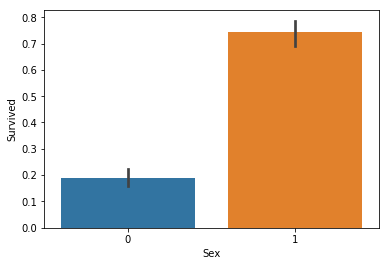

In [10]:
#convert gender into binary data
X['Sex'] = np.where(titanic['Sex']=='male',0,1)
sns.barplot(X['Sex'],y)

#as seen in the Graph below about 75% of survives are female, thus could be a good predictor

In [11]:
Xvec = X.iloc[:, [0,2,7]] #X['Pclass'] + X['Sex'] + X['Ticket'] 
Xvec.head(3)

,Pclass,Sex,Fare
0,3,0,7.2500
1,1,1,71.2833
2,3,1,7.9250


In [12]:
m = LogisticRegression(C=1e5)
m.fit(Xvec, y)
print(m.score(Xvec, y))
# increases score, thus makes sense to include 

0.7890011223344556


In [13]:
# impute age by assume average age for NaN
impute_numerical_NaNs(X, strategy="mean", missing_values=np.nan)
X['Age'].isna().sum()
X['Age'].tail(10)

881    33.000000
882    22.000000
883    28.000000
884    25.000000
885    39.000000
886    27.000000
887    19.000000
888    29.699118
889    26.000000
890    32.000000
Name: Age, dtype: float64

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
        68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
        85, 86, 87, 88]), <a list of 89 Text xticklabel objects>)

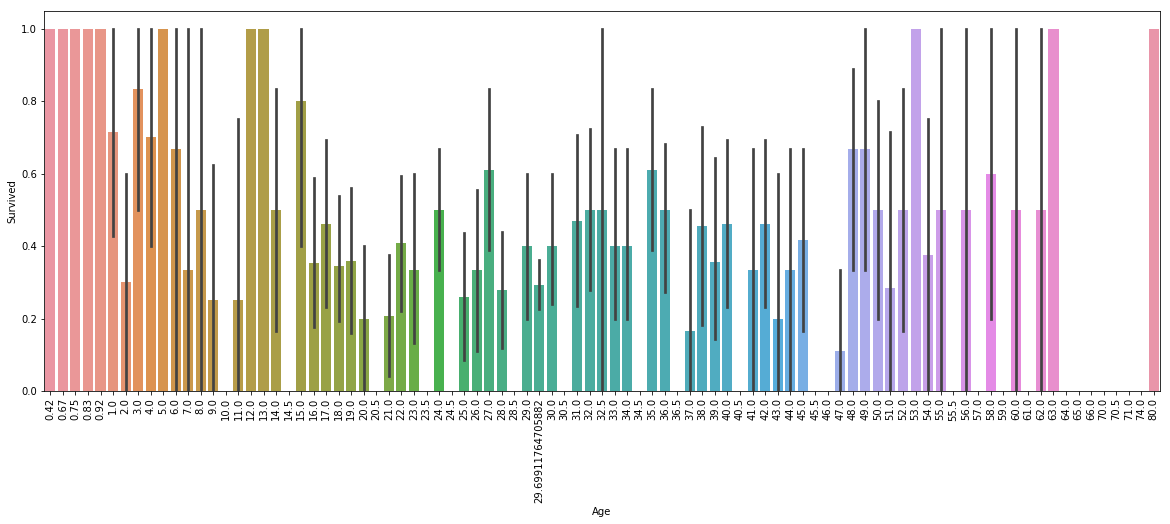

In [14]:
# Plot surviving conditioned on age
fig, ax = plt.subplots(figsize=(20,7))
sns.barplot(X['Age'],y)
plt.xticks(rotation=90)

In [15]:
# binning Age into three different groups
X['Age'] = pd.cut(X['Age'], bins=[0, 14.5, 47, 100], labels=['Child','Adult','Senior'])
X['Age'].tail(10)

881    Adult
882    Adult
883    Adult
884    Adult
885    Adult
886    Adult
887    Adult
888    Adult
889    Adult
890    Adult
Name: Age, dtype: category
Categories (3, object): [Child < Adult < Senior]

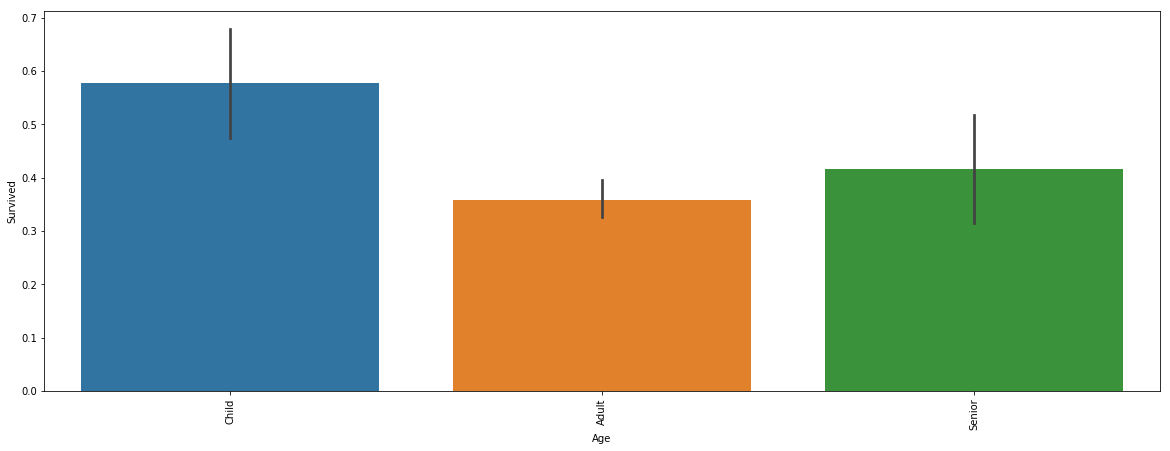

In [16]:
# Plot surviving conditioned on age bins
fig, ax = plt.subplots(figsize=(20,7))
sns.barplot(X['Age'],y)
plt.xticks(rotation=90);
# not most likely to survive when below 15 years of age

In [17]:
Xvec = X.iloc[:, [0,2,3,7]] #X['Pclass'] + X['Sex'] + X['Ticket'] 
Xvec.head(3)

,Pclass,Sex,Age,Fare
0,3.0,0.0,Adult,7.2500
1,1.0,1.0,Adult,71.2833
2,3.0,1.0,Adult,7.9250


In [18]:
# turn 
#one_hot_encoding(Xvec) #@ Paul: did Matthias forgot the prefix in the code or did I do something wrong?
dummies = pd.get_dummies(X['Age'],prefix='Age')
dummies.tail(5)

,Age_Child,Age_Adult,Age_Senior
886,0,1,0
887,0,1,0
888,0,1,0
889,0,1,0
890,0,1,0


In [19]:
#create new Xvec, by concating Xvec and dummies 
Xvec = pd.concat([Xvec, dummies], axis=1)  
Xvec.drop(['Age'], axis=1,inplace=True)
Xvec.drop(['Age_Adult'], axis=1,inplace=True)
Xvec.head(5)

,Pclass,Sex,Fare,Age_Child,Age_Senior
0,3.0,0.0,7.2500,0,0
1,1.0,1.0,71.2833,0,0
2,3.0,1.0,7.9250,0,0
3,1.0,1.0,53.1000,0,0
4,3.0,0.0,8.0500,0,0


In [20]:
m = LogisticRegression(C=1e5)
m.fit(Xvec, y)
print(m.score(Xvec, y))

# score increases by 1 %, so it makes sense to include 

0.792368125701459


In [21]:
# look at scatter matrix
#sns.set(style="ticks")
#sns.pairplot(titanic)

### Evaluate Model

In [22]:
#accuracy
y_hat = m.predict(Xvec)
accuracy = accuracy_score(y, y_hat)
accuracy

0.792368125701459

In [23]:
# precision and recall
from sklearn.metrics import average_precision_score
average_precision = average_precision_score(y, y_hat)
from sklearn.metrics import recall_score
recall = recall_score(y, y_hat)
average_precision, recall

(0.6359424115525727, 0.6929824561403509)

C:\Users\User\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:77: DeprecationWarning: Function plot_precision_recall_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_precision_recall instead.
  warnings.warn(msg, category=DeprecationWarning)


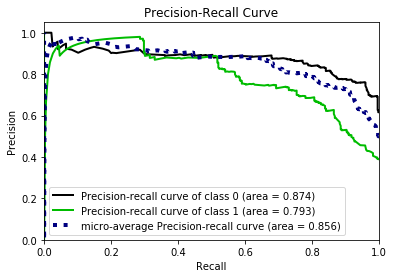

In [24]:
#draw an ROC curve or precision-recall plot
from sklearn.metrics import roc_curve
import scikitplot as skplt

probas = m.predict_proba(Xvec) #, batch_size=64)
skplt.metrics.plot_precision_recall_curve(y, probas)

### Validate your model

In [25]:
#  split your dataset in training and test data
X_train, X_test, y_train, y_test = train_test_split(Xvec, y, test_size=.2, random_state=42)
#cross validation
scores = cross_val_score(m, X_train, y_train, cv=10)
print('CV accuracy scores:') 
print(scores)
print('mean:  %.5f' % np.mean(scores) +'      std:  %.5f' % np.std(scores))

CV accuracy scores:
[0.84722222 0.76388889 0.69444444 0.94444444 0.81690141 0.70422535
 0.70422535 0.78873239 0.75714286 0.88571429]
mean:  0.79069      std:  0.07913


# Tune hyperparameters

In [26]:
# Grid Search
from sklearn.model_selection import GridSearchCV
# comparing different solver methods:
params = {'solver' : ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']} 
g = GridSearchCV(m, param_grid = params)
g.fit(Xvec,y)
g.score(Xvec,y)

C:\Users\User\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\User\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\User\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\User\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\User\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not conver

0.792368125701459

In [27]:
g.best_params_

{'solver': 'newton-cg'}

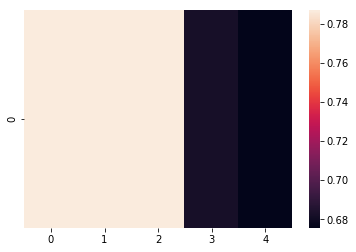

In [28]:
heatvec = g.cv_results_['mean_test_score'].reshape((1,5))
import seaborn as sns
sns.heatmap(heatvec)

# Feature Engineering

### Combining

In [29]:
Xvec['FamilySize'] = X['SibSp'] +X['Parch']
Xvec.tail(5)

,Pclass,Sex,Fare,Age_Child,Age_Senior,FamilySize
886,2.0,0.0,13.00,0,0,0.0
887,1.0,1.0,30.00,0,0,0.0
888,3.0,1.0,23.45,0,0,3.0
889,1.0,0.0,30.00,0,0,0.0
890,3.0,0.0,7.75,0,0,0.0


In [30]:
m = LogisticRegression(C=1e5)
m.fit(Xvec, y)
print(m.score(Xvec, y))  
# seems to improve the accuracy

0.8092031425364759


In [31]:
# cross-validate againg (Note that Xvec has been overwritte in the step before)
X_train, X_test, y_train, y_test = train_test_split(Xvec, y, test_size=.2, random_state=42)
#cross validation
scores = cross_val_score(m, X_train, y_train, cv=10)
print('CV accuracy scores:') 
print(scores)

print('mean:  %.5f' % np.mean(scores) +'      std:  %.5f' % np.std(scores))

CV accuracy scores:
[0.84722222 0.76388889 0.73611111 0.94444444 0.84507042 0.76056338
 0.71830986 0.74647887 0.78571429 0.9       ]
mean:  0.80478      std:  0.07182


### one-hot encoding

In [32]:
#titanic[titanic['Embarked']== 'Q']
X_Embarked = X.set_index(X['Embarked'])
X.sort_values(by= ['Embarked']).tail(5)

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,PassengerId
355,3.0,"Vanden Steen, Mr. Leo Peter",0.0,Adult,0.0,0.0,345783,9.5000,NaN,S,356.0
344,2.0,"Fox, Mr. Stanley Hubert",0.0,Adult,0.0,0.0,229236,13.0000,NaN,S,345.0
445,1.0,"Dodge, Master. Washington",0.0,Child,0.0,2.0,33638,81.8583,A34,S,446.0
61,1.0,"Icard, Miss. Amelie",1.0,Adult,0.0,0.0,113572,80.0000,B28,NaN,62.0
829,1.0,"Stone, Mrs. George Nelson (Martha Evelyn)",1.0,Senior,0.0,0.0,113572,80.0000,B28,NaN,830.0


In [33]:
X_EmbarkedFare = X.groupby('Embarked')[['Fare']].mean()
X_EmbarkedFare 

,Fare
Embarked,
C,59.954144
Q,13.276030
S,27.079812


In [36]:
X_EmbarkedPclass = X.groupby('Embarked')[['Pclass']].mean()
X_EmbarkedPclass

,Pclass
Embarked,
C,1.886905
Q,2.909091
S,2.350932


In [37]:
# given that both NaN for are from Pclass = 1 and paid 80 € it shall be imputed that they embarked from 'C'
X['Embarked'].fillna('C')
dummies2 = pd.get_dummies(X['Embarked'],prefix='Em')
dummies2.tail(5)

,Em_C,Em_Q,Em_S
886,0,0,1
887,0,0,1
888,0,0,1
889,1,0,0
890,0,1,0


In [38]:
#create new Xvec, by concating Xvec and dummies 
Xvec = pd.concat([Xvec, dummies2], axis=1)  
#Xvec.drop(['Age'], axis=1,inplace=True)
Xvec.drop(['Em_Q'], axis=1,inplace=True)
Xvec.head(5)

,Pclass,Sex,Fare,Age_Child,Age_Senior,FamilySize,Em_C,Em_S
0,3.0,0.0,7.2500,0,0,1.0,0,1
1,1.0,1.0,71.2833,0,0,1.0,1,0
2,3.0,1.0,7.9250,0,0,0.0,0,1
3,1.0,1.0,53.1000,0,0,1.0,0,1
4,3.0,0.0,8.0500,0,0,0.0,0,1


In [39]:
# run model
m = LogisticRegression(C=1e5)
m.fit(Xvec, y)
print(m.score(Xvec, y))  
# seems to improve the accuracy

0.7946127946127947


In [40]:
# cross-validate againg (Note that Xvec has been overwritte in the step before)
X_train, X_test, y_train, y_test = train_test_split(Xvec, y, test_size=.2, random_state=42)
#cross validation
scores = cross_val_score(m, X_train, y_train, cv=10)
print('CV accuracy scores:') 
print(scores)

print('mean:  %.5f' % np.mean(scores) +'      std:  %.5f' % np.std(scores))

CV accuracy scores:
[0.83333333 0.73611111 0.72222222 0.90277778 0.87323944 0.76056338
 0.69014085 0.76056338 0.78571429 0.91428571]
mean:  0.79790      std:  0.07455


In [41]:
# Does not seem to improve accuracy, therefore dropped again
# might be because embarkedment relataed to Pclass and Fare

Xvec.drop(['Em_C'], axis=1,inplace=True)
Xvec.drop(['Em_S'], axis=1,inplace=True)
Xvec.head(5)

,Pclass,Sex,Fare,Age_Child,Age_Senior,FamilySize
0,3.0,0.0,7.2500,0,0,1.0
1,1.0,1.0,71.2833,0,0,1.0
2,3.0,1.0,7.9250,0,0,0.0
3,1.0,1.0,53.1000,0,0,1.0
4,3.0,0.0,8.0500,0,0,0.0


### scaling the data

In [42]:
PclassAndFare = Xvec.iloc[:,[0,2]]
scaler = MinMaxScaler()
Xvec_scaled = scaler.fit_transform(PclassAndFare)#####
Xvec_scaled

array([[1.        , 0.01415106],
       [0.        , 0.13913574],
       [1.        , 0.01546857],
       ...,
       [1.        , 0.04577135],
       [0.        , 0.0585561 ],
       [1.        , 0.01512699]])

In [43]:
Xvec['Pclass'] = Xvec_scaled[:,0]

In [44]:
Xvec['Fare'] = Xvec_scaled[:,1]

In [45]:
# checking form improvement 
m = LogisticRegression(C=1e5)
m.fit(Xvec, y)
print(m.score(Xvec, y))

# seems to bring slight improvement

0.8092031425364759


In [46]:
# cross-validate againg (Note that Xvec has been overwritte in the step before)
X_train, X_test, y_train, y_test = train_test_split(Xvec, y, test_size=.2, random_state=42)
#cross validation
scores = cross_val_score(m, X_train, y_train, cv=10)
print('CV accuracy scores:') 
print(scores)

print('mean:  %.5f' % np.mean(scores) +'      std:  %.5f' % np.std(scores))

CV accuracy scores:
[0.84722222 0.76388889 0.73611111 0.94444444 0.84507042 0.76056338
 0.71830986 0.74647887 0.78571429 0.9       ]
mean:  0.80478      std:  0.07182


In [59]:
# result of cross-validation: no improvement compared to non-scaled data

# Apply a Random Forest

### Support Vector Machines

In [48]:
from sklearn import svm
Cs = [0.001, 0.01, 0.1, 1, 10]
gammas = [0.001, 0.01, 0.1, 1]
params2 = {'C': Cs, 'gamma' : gammas}
g2 = GridSearchCV(svm.SVC(kernel='rbf'), params2, cv=5)
g2.fit(Xvec, y)
print(g2.best_params_)

{'C': 10, 'gamma': 0.1}


In [49]:
## use best hyper parameters
svc = svm.SVC(C = 10, gamma=0.1)
X_train, X_test, y_train, y_test = train_test_split(Xvec, y, test_size=.2, random_state=42)
svc.fit(X_train, y_train)
y_hat2 = svc.predict(X_test)

result_train = svc.score(X_train, y_train)
restult_score = cross_val_score(svc,X_train, y_train, cv=5)
result_val = restult_score.mean()
print('CV accuracy scores:') 
print(restult_score)

print('mean:  %.5f' % result_train +'      std:  %.5f' % result_val)

CV accuracy scores:
[0.85314685 0.84615385 0.81118881 0.8028169  0.85106383]
mean:  0.83567      std:  0.83287


### Random Forests

In [50]:
from sklearn.ensemble import RandomForestClassifier  
rf = RandomForestClassifier(n_estimators=100)
rf.fit(X_train, y_train)
rf_predictions = rf.predict(X_test)
accuracy_rf = round(rf.score(X_test, y_test) * 100, 2)
accuracy_rf

79.89

In [58]:
X_train, X_test, y_train, y_test = train_test_split(Xvec, y, test_size=.2, random_state=42)

rf.fit(X_train, y_train)
Y_pred = rf.predict(X_test)
result_train = svc.score(X_train, y_train)
restult_score = cross_val_score(svc,X_train, y_train, cv=5)
result_val = restult_score.mean()

print('CV accuracy scores:') 
print(restult_score)
print('mean:  %.5f' % result_train +'      std:  %.5f' % result_val)

CV accuracy scores:
[0.85314685 0.84615385 0.81118881 0.8028169  0.85106383]
mean:  0.83567      std:  0.83287


### Check on Predict Set

#### - still to be done -

In [ ]:
# do same data manipulation to testing set
Xpredict = titanic_predict
Xpredict.tail(5)

In [ ]:
Xpredict.isnull().sum()

In [ ]:
# Sex into binary
Xpredict['Sex'] = np.where(Xpredict['Sex']=='male',0,1)

# in Age: mean for NaN 
impute_numerical_NaNs(Xpredict, strategy="mean", missing_values=np.nan)
Xpredict['Age'].isna().sum()
Xpredict['Age'].tail(10)

In [ ]:
# binning Age into three different groups
Xpredict['Age'] = pd.cut(Xpredict['Age'], bins=[0, 14.5, 47, 100], labels=['Child','Adult','Senior'])
Xpredict['Age'].tail(10)

In [ ]:
dummiestest = pd.get_dummies(Xpredict['Age'],prefix='Age')
dummiestest.tail(5)

In [ ]:
Xpredict = pd.concat([Xpredict, dummies], axis=1)  
Xpredict.drop(['Age_Adult'], axis=1,inplace=True)
Xpredict.head(5)

In [ ]:
Xpredict.drop(['Age_Adult'], axis=1,inplace=True)
m = LogisticRegression(C=1e5)
m.fit(Xvec, y)
print(m.score(Xpredict, y))